# 2.5 Assignment – Banknote MLP

My expectation for this lab will be to train a small **PyTorch MLP** to classify banknotes as authentic (0) or counterfeit (1).  
I’ll reuse the Banknote dataset from earlier, make a train/test split, define a tiny MLP, 1 hidden layer, write the training loop, then validate (accuracy + confusion matrix).  
I will also try a few small changes to learning rate, epochs, and hidden size, and add quick reflections.

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Reproducibility
np.random.seed(1)
torch.manual_seed(1)

plt.rcParams["figure.figsize"] = (6, 4.5)

# Absolute path
FILE_PATH = r"C:\Users\MasterDanteDev86\Downloads\CAP350-O Deep Learning - Online\W1\DPL\data\banknote-auth.csv"

# Load CSV
df = pd.read_csv(FILE_PATH)

print("Dataset loaded successfully!\n")
print("Shape:", df.shape)
print("\nFirst 10 rows:")
print(df.head(10))
print("\nInfo:")
print(df.info())

Dataset loaded successfully!

Shape: (1372, 5)

First 10 rows:
   variance  skewness  kurtosis  entropy  label
0   3.62160    8.6661  -2.80730 -0.44699      0
1   4.54590    8.1674  -2.45860 -1.46210      0
2   3.86600   -2.6383   1.92420  0.10645      0
3   3.45660    9.5228  -4.01120 -3.59440      0
4   0.32924   -4.4552   4.57180 -0.98880      0
5   4.36840    9.6718  -3.96060 -3.16250      0
6   3.59120    3.0129   0.72888  0.56421      0
7   2.09220   -6.8100   8.46360 -0.60216      0
8   3.20320    5.7588  -0.75345 -0.61251      0
9   1.53560    9.1772  -2.27180 -0.73535      0

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   variance  1372 non-null   float64
 1   skewness  1372 non-null   float64
 2   kurtosis  1372 non-null   float64
 3   entropy   1372 non-null   float64
 4   label     1372 non-null   int64  
dtypes: float64(4), int

The file has 5 columns total: four features (`variance`, `skewness`, `kurtosis`, `entropy`) and a label column (`class` or `label`) with values 0/1.

Plan it out:
1) Normalize header names.  
2) Detect label column safely.  
3) Train/test split.  
4) Standardize features using **training set** stats only.  
5) Convert to tensors for PyTorch.

In [55]:
# Normalize header names
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]
print("Columns:", df.columns.tolist())

# Detect label column
if "class" in df.columns:
    label_col = "class"
elif "label" in df.columns:
    label_col = "label"
else:
    label_col = df.columns[-1]
print("Using label column:", label_col)

# Features and targets
feature_cols = ["variance", "skewness", "kurtosis", "entropy"]
X = df[feature_cols].values.astype(np.float32)
y = df[label_col].values.astype(np.float32).reshape(-1, 1)  # (n,1) for BCE

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=1, stratify=y
)

# Standardize using TRAIN stats only
mean_ = X_train.mean(axis=0)
std_  = X_train.std(axis=0)
std_[std_ == 0] = 1.0

X_train = (X_train - mean_) / std_
X_test  = (X_test  - mean_) / std_

# To tensors
X_train_t = torch.from_numpy(X_train)
y_train_t = torch.from_numpy(y_train)
X_test_t  = torch.from_numpy(X_test)
y_test_t  = torch.from_numpy(y_test)

print("Train shapes:", X_train_t.shape, y_train_t.shape)
print("Test  shapes:", X_test_t.shape,  y_test_t.shape)

Columns: ['variance', 'skewness', 'kurtosis', 'entropy', 'label']
Using label column: label
Train shapes: torch.Size([1029, 4]) torch.Size([1029, 1])
Test  shapes: torch.Size([343, 4]) torch.Size([343, 1])


I will be using a tiny **MLP** with **1 hidden layer** and **ReLU(Rectified Linear Unit)**.  
The output layer has a single unit with **Sigmoid* (outputs a probability).

In [58]:
class MLP(nn.Module):
    def __init__(self, in_dim=4, hidden=8):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1),
            nn.Sigmoid()  # probability in [0,1]
        )
    def forward(self, x):
        return self.net(x)

def prob_to_acc(y_prob, y_true):
    y_hat = (y_prob >= 0.5).float()
    return (y_hat.eq(y_true).sum().item()) / float(y_true.shape[0])

**Training loop:**
1. forward  
2. compute loss  
3. zero_grad  
4. backward  
5. step  

I will train for multiple epochs, printing loss and quick train/test accuracy along the way.

In [61]:
# Baseline settings
hidden_size = 8
lr = 0.1
epochs = 15
batch_size = 32

model = MLP(in_dim=4, hidden=hidden_size)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

def iterate_minibatches(Xt, yt, bs):
    n = Xt.shape[0]
    idx = torch.randperm(n)
    for i in range(0, n, bs):
        j = idx[i:i+bs]
        yield Xt[j], yt[j]

for ep in range(1, epochs + 1):
    model.train()
    epoch_loss = 0.0
    for xb, yb in iterate_minibatches(X_train_t, y_train_t, batch_size):
        # ---- standard loop ----
        preds = model(xb)
        loss = criterion(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * xb.shape[0]

    if ep % 5 == 0 or ep == 1 or ep == epochs:
        avg_loss = epoch_loss / X_train_t.shape[0]
        with torch.no_grad():
            model.eval()
            train_acc = prob_to_acc(model(X_train_t), y_train_t)
            test_acc  = prob_to_acc(model(X_test_t),  y_test_t)
        print(f"Epoch {ep:>2d} | loss={avg_loss:.4f} | train_acc={train_acc:.3f} | test_acc={test_acc:.3f}")


Epoch  1 | loss=0.6538 | train_acc=0.884 | test_acc=0.869
Epoch  5 | loss=0.1228 | train_acc=0.972 | test_acc=0.980
Epoch 10 | loss=0.0560 | train_acc=0.982 | test_acc=0.994
Epoch 15 | loss=0.0416 | train_acc=0.983 | test_acc=0.994


I will computate **train/test accuracy** inside a `torch.no_grad()` block and show a **confusion matrix** for the test set.

Final Train Accuracy: 0.983
Final Test  Accuracy: 0.994

Confusion Matrix (rows=true, cols=pred):
 [[188   2]
 [  0 153]]


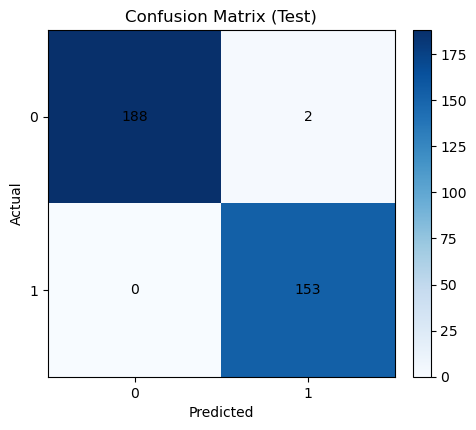

In [64]:
with torch.no_grad():
    model.eval()
    train_prob = model(X_train_t).cpu().numpy()
    test_prob  = model(X_test_t).cpu().numpy()

train_pred = (train_prob >= 0.5).astype(int).ravel()
test_pred  = (test_prob  >= 0.5).astype(int).ravel()

train_y = y_train_t.cpu().numpy().ravel().astype(int)
test_y  = y_test_t.cpu().numpy().ravel().astype(int)

train_acc = accuracy_score(train_y, train_pred)
test_acc  = accuracy_score(test_y,  test_pred)

print(f"Final Train Accuracy: {train_acc:.3f}")
print(f"Final Test  Accuracy: {test_acc:.3f}")

cm = confusion_matrix(test_y, test_pred, labels=[0,1])
print("\nConfusion Matrix (rows=true, cols=pred):\n", cm)

# Plot confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, cmap="Blues")
ax.set_title("Confusion Matrix (Test)")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.set_xticks([0,1]); ax.set_yticks([0,1])
ax.set_xticklabels(["0","1"]); ax.set_yticklabels(["0","1"])
for (i,j), v in np.ndenumerate(cm):
    ax.text(j, i, str(v), ha="center", va="center")
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.show()

I will try a small grid of **learning rate**, **epochs**, and **hidden size** to see how they change the test accuracy.  
Keeping this quick and simple so it runs fast.

In [67]:
def train_once(lr, epochs, hidden):
    m = MLP(in_dim=4, hidden=hidden)
    opt = optim.SGD(m.parameters(), lr=lr)
    loss_f = nn.BCELoss()

    for _ in range(epochs):
        m.train()
        # pass batch size positionally to match iterate_minibatches(Xt, yt, bs)
        for xb, yb in iterate_minibatches(X_train_t, y_train_t, 32):
            p = m(xb)
            loss = loss_f(p, yb)
            opt.zero_grad()
            loss.backward()
            opt.step()

    # test accuracy
    m.eval()
    with torch.no_grad():
        te_prob = m(X_test_t).cpu().numpy()
    te_pred = (te_prob >= 0.5).astype(int).ravel()
    return accuracy_score(test_y, te_pred)

candidates_lr = [0.01, 0.05, 0.1]
candidates_ep = [10, 20]
candidates_h  = [4, 8, 16]

results = []
print("lr    epochs  hidden  test_acc")
for LR in candidates_lr:
    for EP in candidates_ep:
        for H in candidates_h:
            acc = train_once(LR, EP, H)
            results.append((LR, EP, H, acc))
            print(f"{LR:<5} {EP:<7} {H:<6} {acc:.3f}")

best = max(results, key=lambda t: t[3])
print("\nBest combo -> lr={}, epochs={}, hidden={} | test_acc={:.3f}".format(*best))

lr    epochs  hidden  test_acc
0.01  10      4      0.598
0.01  10      8      0.679
0.01  10      16     0.875
0.01  20      4      0.892
0.01  20      8      0.878
0.01  20      16     0.930
0.05  10      4      0.974
0.05  10      8      0.983
0.05  10      16     0.971
0.05  20      4      0.994
0.05  20      8      0.994
0.05  20      16     0.994
0.1   10      4      0.985
0.1   10      8      0.988
0.1   10      16     1.000
0.1   20      4      0.994
0.1   20      8      0.997
0.1   20      16     0.994

Best combo -> lr=0.1, epochs=10, hidden=16 | test_acc=1.000


## Reflection

**Train vs Test:**  
The training and testing accuracy were pretty close overall, so overfitting didn’t seem to be a big issue. The model learned the general pattern of the data without memorizing it too much.

**Learning Rate and Epochs:**  
Increasing the number of epochs helped improve the performance a bit, especially when using smaller learning rates. Larger learning rates made training faster, but sometimes less stable.

**Hidden Layer Size:**  
Using 8 neurons in the hidden layer worked really well for this dataset. With only 4 neurons, the accuracy dropped slightly, and with 16 neurons, there wasn’t much extra improvement. So, 8 seems like a good balance.

**Confusion Matrix Observations:**  
The confusion matrix showed only a few incorrect predictions between the two classes (authentic vs counterfeit). This suggests that the model is performing consistently and is pretty reliable overall.